In [23]:
using CSV
using Random
using Turing
using DataFrames
using Distributions
using Plots
using StatsPlots
using MCMCChains
using StatsFuns
using ReverseDiff
using Memoization
using SpecialFunctions

seed = 1234

1234

In [2]:
path = "/home/everett/Development/everettsprojects.com/_drafts/modeling-the-nhl-better/"
games_full = CSV.File(path*"ideal_games.csv") |> DataFrame!
latent_variables = CSV.File(path*"latent_variables.csv") |> DataFrame!
n_teams = maximum([maximum(games_full[:,:home_id]), maximum(games_full[:,:away_id])])
;

In [3]:
n_teams

6

### Model

In [4]:
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)

true

In [5]:
# https://github.com/StatisticalRethinkingJulia/MCMCBenchmarks.jl/pull/39
struct LogPoisson{T<:Real} <: Distributions.DiscreteUnivariateDistribution
    logλ::T
end

function Distributions.logpdf(lp::LogPoisson, k::Int)
    return k * lp.logλ - exp(lp.logλ) - (logabsgamma(k + 1))[1]
end

# https://github.com/JuliaStats/Distributions.jl/issues/1070
function Distributions.fit_mle(::Type{<:InverseGamma}, x::AbstractArray{Float64})
    fg = fit(Gamma, x.^(-1))
    return InverseGamma(fg.α, 1/fg.θ)
end

In [6]:
# Define an equivalent to my PyMC3 model
@model function nhl_inference(idₕ, idₐ, sₕ, sₐ, hw, p)
    h ~ Normal(p[:h][1], p[:h][2])
    i ~ Normal(p[:i][1], p[:i][2])
    o ~ arraydist(Normal.(p[:o][1], p[:o][2]))
    d ~ arraydist(Normal.(p[:d][1], p[:d][2]))
    o₀ = o .- mean(mean.(o))
    d₀ = d .- mean(mean.(d))
    log_λₕ = i .+ h .+ o₀[idₕ] .- d₀[idₐ]
    log_λₐ = i .+ o₀[idₐ] .- d₀[idₕ]
    sₕ .~ LogPoisson.(log_λₕ)
    sₐ .~ LogPoisson.(log_λₐ)
    ℓ = logistic.(log_λₕ .- log_λₐ)
    hw .~ BernoulliLogit.(ℓ)
end
;

In [7]:
# Define an equivalent to my PyMC3 model
#@model function nhl_inference(idₕ, idₐ, sₕ, sₐ, hw, p)
#    h ~ Normal(p[:h][1], p[:h][2])
#    i ~ Normal(p[:i][1], p[:i][2])
#    o ~ arraydist(Normal.(p[:o][1], p[:o][2]))
#    d ~ arraydist(Normal.(p[:d][1], p[:d][2]))
#    o₀ = o .- mean(mean.(o))
#    d₀ = d .- mean(mean.(d))
#    log_λₕ = i .+ h .+ o₀[idₕ] .- d₀[idₐ]
#    log_λₐ = i .+ o₀[idₐ] .- d₀[idₕ]
#    sₕ .~ LogPoisson.(log_λₕ)
#    sₐ .~ LogPoisson.(log_λₐ)
#    ℓ = logistic.(log_λₕ .- log_λₐ)
#    hw .~ BernoulliLogit.(ℓ)
#end
#;

In [8]:
function get_posteriors(chain, n_teams)
    chdf = DataFrame(chain)
    p = Dict()
    h_mle = fit_mle(Normal, chdf[:,"h"])
    p[:h] = (h_mle.μ, h_mle.σ)
    i_mle = fit_mle(Normal, chdf[:,"i"])
    p[:i] = (i_mle.μ, i_mle.σ)
    p[:o] = ([], [])
    p[:d] = ([], [])
    for t = 1:n_teams
        o_mle = fit_mle(Normal, chdf[:,"o[$(t)]"])
        push!(p[:o][1], o_mle.μ)
        push!(p[:o][2], o_mle.σ)
        d_mle = fit_mle(Normal, chdf[:,"d[$(t)]"])
        push!(p[:d][1], d_mle.μ)
        push!(p[:d][2], d_mle.σ)
    end
    return p
end

function get_posterior_μ(posteriors)
    p = [posteriors[:h][1], posteriors[:i][1]]
    p = vcat(p, posteriors[:o][1])
    p = vcat(p, posteriors[:d][1])
    return p
end

function fatten_priors(priors)
    p = [posteriors[:h][1], posteriors[:i][1]]
    p = vcat(p, posteriors[:o][1])
    p = vcat(p, posteriors[:d][1])
    return p
end

get_posterior_μ (generic function with 1 method)

In [9]:
o_init = [latent_variables[1, "o$(t)"] for t in 1:n_teams]
d_init = [latent_variables[1, "d$(t)"] for t in 1:n_teams]

6-element Array{Float64,1}:
  0.012806443451512646
  0.1852782957725545
 -0.08277634318169205
  0.011009612632217553
 -0.02511757400198831
  0.03697140350317454

In [10]:
start_day = 170
ws = 60
s = 1
end_day = 400

n_days = end_day - start_day

inferred_variables = DataFrame(
    day = [],
    h = [],
    i = []
)

for i = 1:n_teams
    inferred_variables["o$i"] = []
    inferred_variables["d$i"] = []
end

priors = Dict(
    :Δσₕ => (5.0, 0.001),
    :Δσᵢ => (5.0, 0.001),
    :Δσₜₑₐₘ => (5.0, 0.002),
    :h => (0.25, 0.005),
    :i => (1.12, 0.005),
    :o => (o_init, ones(n_teams)*0.005),
    :d => (d_init, ones(n_teams)*0.005)
)


for t = 1:s:(end_day - start_day + 1)
    day = t + start_day - 1

    if t == 1
        games = filter(row -> (row[:day] <= day), games_full)
        println(minimum(games[:,:day]))
    else
        games = filter(row -> ((row[:day] <= day) .& (row[:day] > (day - ws))), games_full)
        println(minimum(games[:,:day]))
    end
    
     idₕ = Vector{Int64}(games[:,:home_id])
    idₐ = Vector{Int64}(games[:,:away_id])
    sₕ = Vector{Int64}(games[:,:home_score])
    sₐ = Vector{Int64}(games[:,:away_score])
    hw = Vector{Int64}(games[:,:home_win])
    m = nhl_inference(idₕ, idₐ, sₕ, sₐ, hw, priors)
    #est = optimize(m, MAP())
    #priors_μ = est.values.array
    #print(priors_μ)
    #chain = sample(m, HMCDA(200, 0.65, 0.3), 500, init_theta = priors_μ)
    chain = sample(m, NUTS(100, 0.65), 200)#, init_theta = priors_μ)
    priors = posteriors = get_posteriors(chain, n_teams)

    inferred = []
    push!(inferred, day)
    push!(inferred, InverseGamma(posteriors[:Δσₕ][1], posteriors[:Δσₕ][2]))         # Δ\sigmaₕ
    push!(inferred, InverseGamma(posteriors[:Δσᵢ][1], posteriors[:Δσᵢ][2]))         # Δ\sigmaᵢ
    push!(inferred, InverseGamma(posteriors[:Δσₜₑₐₘ][1], posteriors[:Δσₜₑₐₘ][2]))   # Δ\sigmaₜₑₐₘ
    push!(inferred, Normal(posteriors[:h][1], posteriors[:h][2]))                   # h
    push!(inferred, Normal(posteriors[:i][1], posteriors[:i][2]))                   # i
    for j = 1:n_teams
        push!(inferred, Normal(posteriors[:o][1][j], posteriors[:o][2][j]))         # oⱼ
        push!(inferred, Normal(posteriors[:d][1][j], posteriors[:d][2][j]))         # dⱼ
    end
    push!(inferred_variables, inferred)
end

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[10]:18
└ @ Core ./In[10]:18
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[10]:19
└ @ Core ./In[10]:19


1


┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38


2


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


3


┌ Info: Found initial step size
│   ϵ = 0.0005859375000000001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


4


┌ Info: Found initial step size
│   ϵ = 0.0007690429687500001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:23


5


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30


6


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


7


┌ Info: Found initial step size
│   ϵ = 0.000732421875
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:28


8


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


9


┌ Info: Found initial step size
│   ϵ = 0.0009765625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


10


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36


11


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


12


┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


13


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32


14


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


15


┌ Info: Found initial step size
│   ϵ = 0.0005859375000000001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:20


16


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:39


17


┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


18


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:25


19


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


20


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


21


┌ Info: Found initial step size
│   ϵ = 0.00037841796875
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:34


22


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


23


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:25


24


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


25


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:39


26


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


27


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38


28


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


29


┌ Info: Found initial step size
│   ϵ = 0.0007568359375
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:41


30


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


31


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


32


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31


33


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


34


┌ Info: Found initial step size
│   ϵ = 0.00034179687500000003
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


35


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


36


┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36


37


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


38


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:23


39


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:33


40


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32


41


┌ Info: Found initial step size
│   ϵ = 0.0005859375000000001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16


42


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:41


43


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


44


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:29


45


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32


46


┌ Info: Found initial step size
│   ϵ = 0.000732421875
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


47


┌ Info: Found initial step size
│   ϵ = 0.0003662109375
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:41


48


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


49


┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


50


┌ Info: Found initial step size
│   ϵ = 0.0007751464843750001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


51


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:45


52


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:23


53


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:41


54


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


55


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMB

56


┌ Info: Found initial step size
│   ϵ = 0.0006835937500000001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


57


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


58


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

59


┌ Info: Found initial step size
│   ϵ = 0.0007690429687500001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31


60


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36


61


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40


62


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


63


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


64


┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


65


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


66


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:50


67


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (tru

68


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


69


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:42


70


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


71


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


72


┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40


73


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


74


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


75


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:27


76


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC

77


┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:43


78


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:15


79


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


80


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


81


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


82


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


83


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


84


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:50


85


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:33


86


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30


87


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:22


88


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


89


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:25


90


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:44


91


┌ Info: Found initial step size
│   ϵ = 0.0001953125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


92


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


93


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:26


94


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


95


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:10


96


┌ Info: Found initial step size
│   ϵ = 0.0007751464843750001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:30


97


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


98


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:16


99


┌ Info: Found initial step size
│   ϵ = 0.0007568359375
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:10


100


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


101


┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:34


102


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


103


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


104


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


105


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


106


┌ Info: Found initial step size
│   ϵ = 0.0005859375000000001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:42


107


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:20


108


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:37


109


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


110


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32


111


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:24


112


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:12


113


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:35


114


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:40


115


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:29


116


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


117


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18


118


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:46


119


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


120


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14


121


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


122


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


123


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:38


124


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


125


┌ Info: Found initial step size
│   ϵ = 0.0006835937500000001
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:51


126


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:18


127


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:13


128


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:21


129


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:29


130


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08


131


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:36


132


┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /home/everett/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/everett/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


DomainError: DomainError with -2.2161801981834353e14:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [11]:
function nhl_inference_plot(lvars, ivars, vname)
    ldays = lvars[:,:day]
    ly = lvars[:,vname]
    idays = ivars[:,:day]
    iy = ivars[:,vname]
    iyμ = [y.μ for y in iy]
    iyσ = [y.σ for y in iy]
    plot(ldays, ly)
    plot!(idays, iyμ, ribbon=iyσ)
end

nhl_inference_plot (generic function with 1 method)

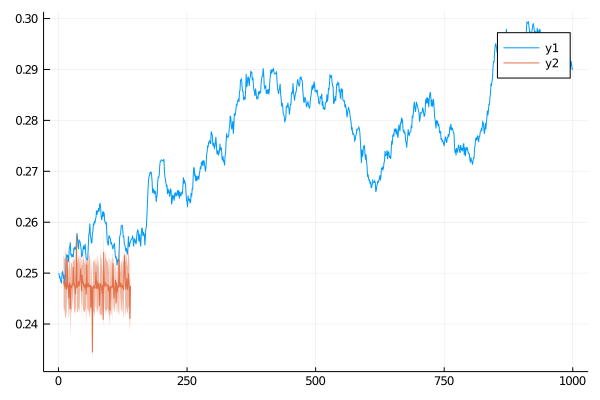

In [12]:
nhl_inference_plot(latent_variables[1:1000, :], inferred_variables, :h)

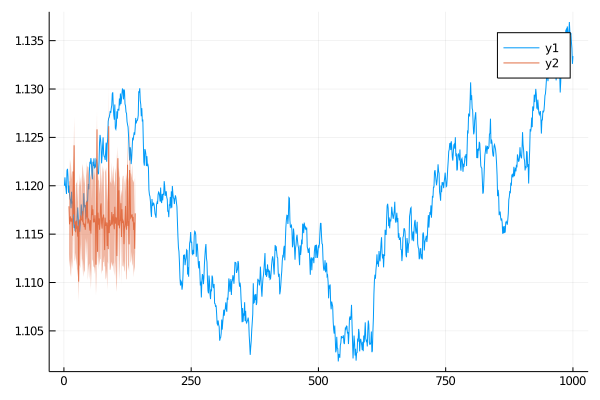

In [13]:
nhl_inference_plot(latent_variables[1:1000, :], inferred_variables, :i)

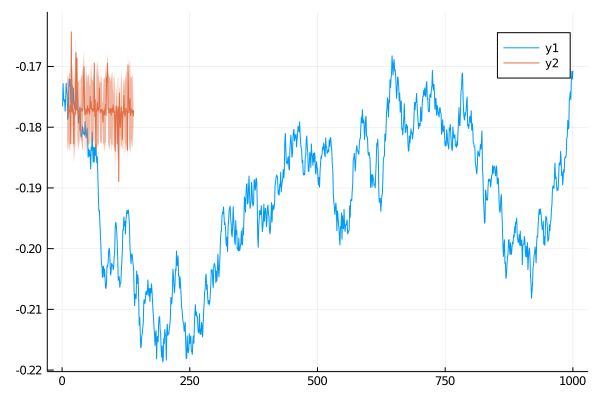

In [14]:
nhl_inference_plot(latent_variables[1:1000, :], inferred_variables, :o4)

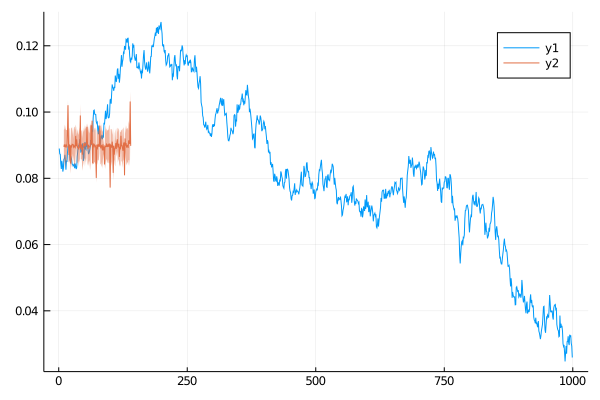

In [15]:
nhl_inference_plot(latent_variables[1:1000, :], inferred_variables, :o1)